In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 

from utils import mlp,train_test_model
from utils.scp_utils.scp import SCP
from utils.ewc_utils.onlineEWC import OnlineEWC
from utils.mas_utils.mas import MAS

from data.permuted_MNIST import get_permuted_mnist

import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from IPython import display
import time

In [2]:
import os
if not os.path.isdir('saved_models/'):
    os.mkdir('saved_models/')

## Set configurations

In [3]:
epochs = 20
lr = 1e-4 
batch_size = 100 
input_size = 784
hidden_sizes = [1024,512,256]
output_size = 10
num_task=2
activation='ReLU'
device='cuda:1'

## Load dataset

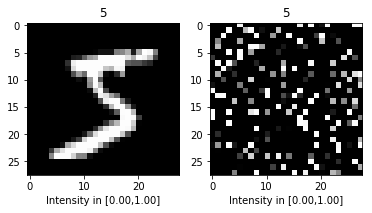

In [4]:
train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

## First we perform MAS

In [ ]:
mas_alpha=0.25
mas_importance=2e+4

In [ ]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
mas= MAS(model,device=device,alpha=mas_alpha)
## performing training
loss_mas, acc_mas = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss_mas[task] = []
    acc_mas[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_mas[task].append(train_test_model.mas_train_classifier(mas=mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_mas[sub_task].append(train_test_model.test_classifier(model=mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    mas.consolidate(train_loader[task])    
    torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
    
    importance_MAS=list()
    for i,n in enumerate(mas._precision_matrices.keys()):
        importance_MAS.append(mas._precision_matrices[n].detach().cpu().numpy())